In [2]:
import driftax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax

from driftax.datasets import sample_checkerboard, sample_swiss_roll
from driftax.drift import compute_drift, drifting_loss
from driftax.models import MLPGenerator

print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0)]


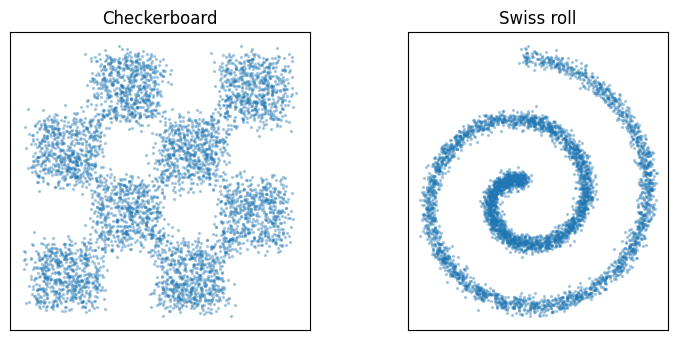

In [3]:
def plot_dataset_samples(seed=0, n=5000, noise_cb=0.05, noise_sr=0.03):
    k = jax.random.PRNGKey(seed)
    k1, k2 = jax.random.split(k, 2)

    cb = np.array(sample_checkerboard(k1, n, noise=noise_cb))
    sr = np.array(sample_swiss_roll(k2, n, noise=noise_sr))

    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    for ax, (name, pts) in zip(axes, [("Checkerboard", cb), ("Swiss roll", sr)]):
        ax.scatter(pts[:, 0], pts[:, 1], s=2, alpha=0.3)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

plot_dataset_samples(seed=42)


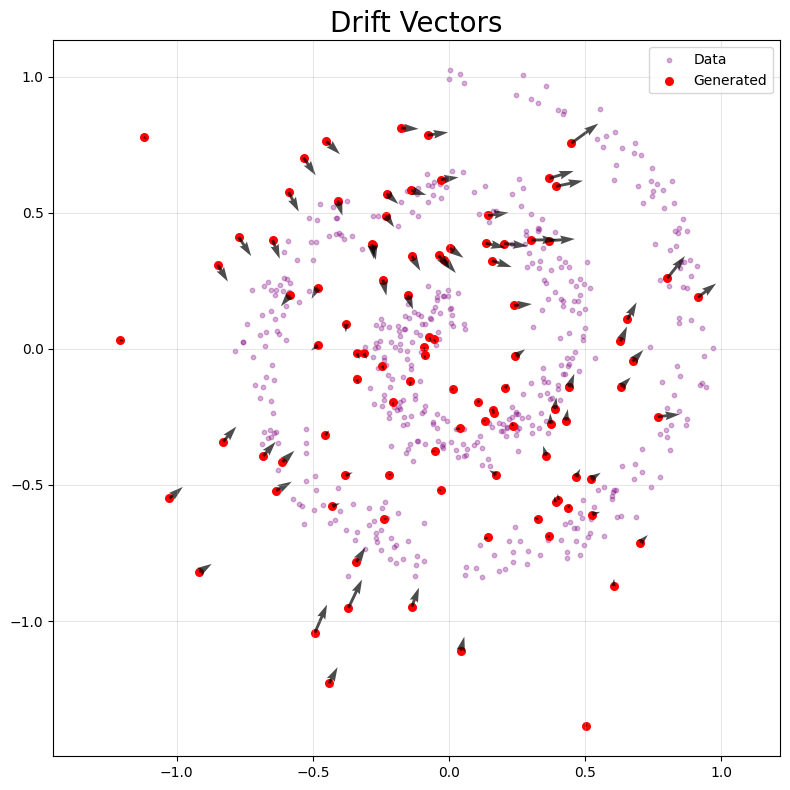

In [19]:
def visualize_drift(dataset="checkerboard", temp=0.2, seed=42, noise=0.05):
    sampler = sample_checkerboard if dataset.lower().startswith("check") else sample_swiss_roll

    key = jax.random.PRNGKey(seed)
    key, k_gen, k_pos = jax.random.split(key, 3)

    gen = 0.5 * jax.random.normal(k_gen, (100, 2), dtype=jnp.float32)
    pos = sampler(k_pos, 500, noise=noise)

    drift = compute_drift(gen, pos, temp=temp)

    gen_np = np.array(gen)
    pos_np = np.array(pos)
    drift_np = np.array(drift)

    plt.figure(figsize=(8, 8))
    plt.scatter(pos_np[:, 0], pos_np[:, 1], s=10, alpha=0.3, c="purple", label="Data")
    plt.scatter(gen_np[:, 0], gen_np[:, 1], s=30, c="red", label="Generated")
    plt.quiver(gen_np[:, 0], gen_np[:, 1], drift_np[:, 0], drift_np[:, 1],
               scale=3, color="black", alpha=0.7, width=0.004)
    plt.legend()
    plt.title(f"Drift Vectors", fontsize=20)
    plt.axis("equal")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_drift(dataset="swiss_roll", temp=0.2)


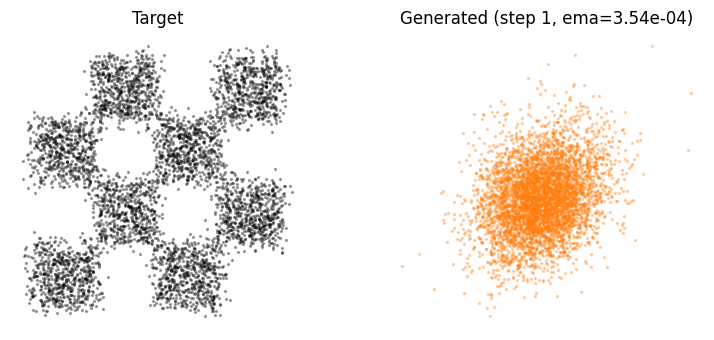

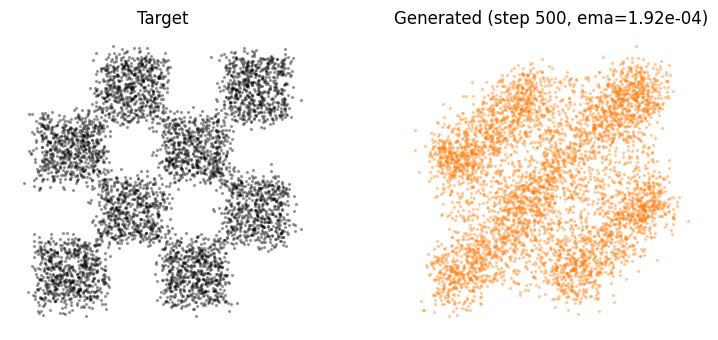

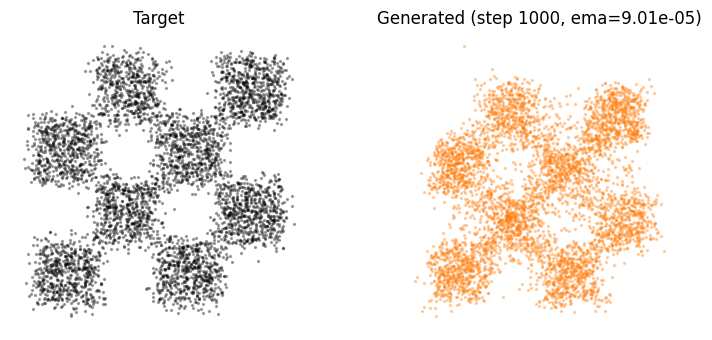

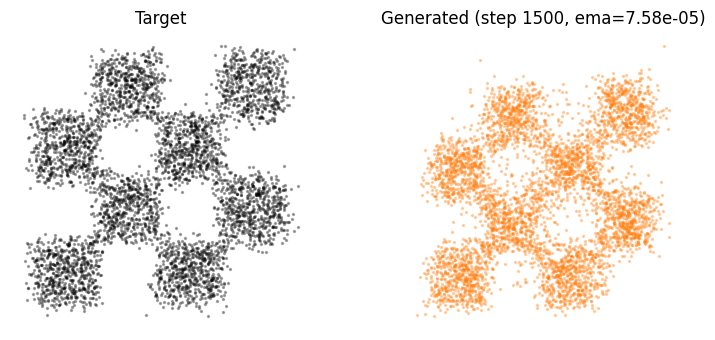

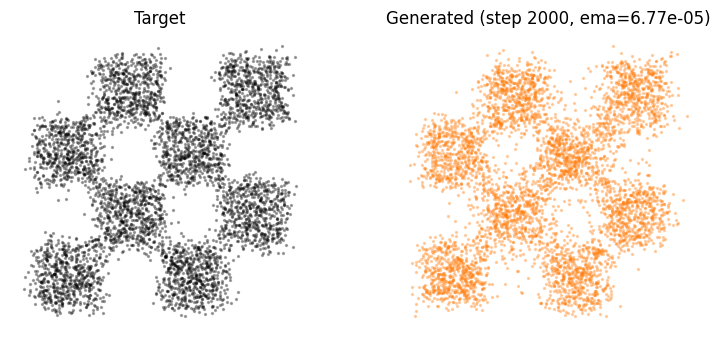

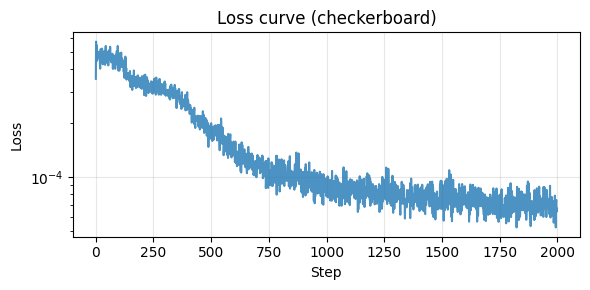

In [5]:
def train_toy(
    dataset="checkerboard",
    steps=2000,
    data_batch_size=2048,
    gen_batch_size=2048,
    lr=1e-3,
    temp=0.05,
    z_dim=32,
    hidden=256,
    plot_every=500,
    seed=42,
    noise=0.05,
):
    sampler = sample_checkerboard if dataset.lower().startswith("check") else sample_swiss_roll

    key = jax.random.PRNGKey(seed)
    key, k_init = jax.random.split(key)

    model = MLPGenerator(in_dim=z_dim, hidden=hidden, out_dim=2)
    params = model.init(k_init, jnp.zeros((1, z_dim), dtype=jnp.float32))

    opt = optax.adam(lr)
    opt_state = opt.init(params)

    @jax.jit
    def step_fn(params, opt_state, key):
        key, k_pos, k_z = jax.random.split(key, 3)
        pos = sampler(k_pos, data_batch_size, noise=noise)
        z = jax.random.normal(k_z, (gen_batch_size, z_dim), dtype=jnp.float32)
        gen = model.apply(params, z)

        loss = drifting_loss(gen, pos, temp=temp)
        grads = jax.grad(lambda p: drifting_loss(model.apply(p, z), pos, temp=temp))(params)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, key, loss

    loss_hist = []
    ema = None

    for s in range(1, steps + 1):
        params, opt_state, key, loss = step_fn(params, opt_state, key)
        loss_val = float(loss)
        loss_hist.append(loss_val)
        ema = loss_val if ema is None else 0.96 * ema + 0.04 * loss_val

        if s == 1 or (plot_every and s % plot_every == 0):
            key, k_gt, k_vis = jax.random.split(key, 3)
            gt = np.array(sampler(k_gt, 5000, noise=noise))
            z = jax.random.normal(k_vis, (5000, z_dim), dtype=jnp.float32)
            vis = np.array(model.apply(params, z))

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
            ax1.scatter(gt[:, 0], gt[:, 1], s=2, alpha=0.3, c="black")
            ax1.set_title("Target"); ax1.set_aspect("equal"); ax1.axis("off")
            ax2.scatter(vis[:, 0], vis[:, 1], s=2, alpha=0.3, c="tab:orange")
            ax2.set_title(f"Generated (step {s}, ema={ema:.2e})"); ax2.set_aspect("equal"); ax2.axis("off")
            plt.tight_layout()
            plt.show()

    loss_hist = np.asarray(loss_hist, dtype=np.float32)
    plt.figure(figsize=(6, 3))
    plt.plot(loss_hist, alpha=0.8)
    plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss curve ({dataset})")
    plt.tight_layout()
    plt.show()

    return params, loss_hist

# Example: train on checkerboard
_ = train_toy(dataset="checkerboard", steps=2000, lr=1e-3, temp=0.05, plot_every=500, seed=42, noise=0.05)
